In [1]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import (ggplot, 
                      aes,
                      geom_line,
                      theme_bw,
                      geom_histogram,
                      scale_x_log10,
                      scale_x_sqrt)
from plotnine_prism import theme_prism
from collections import namedtuple, defaultdict
import numpy as np
import os
import json
from tqdm.notebook import tqdm
from datetime import datetime
from bisect import bisect_left, bisect_right
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20}, style="whitegrid")  

In [3]:
TableConfig = namedtuple("TableConfig", "tname author body utc subforum")

In [4]:
PlotConfig = namedtuple("PlotConfig", "hist_log hist2_log max_hist2")

In [5]:
reddit_config = TableConfig("reddit", "author", "body", "created_utc", "subreddit")
dread_config = TableConfig("dread", "creator_id", "content", "created_on", "board")

In [6]:
def basic_stats(conn: duckdb.DuckDBPyConnection, tconfig: TableConfig, pconfig: PlotConfig):
   #q = duckdb.sql(f"SELECT * FROM {tconfig.tname} LIMIT 1",
   #               connection=conn)    
   #print(q.fetchall())
   ### n_authors
   results = defaultdict(dict)
   n_auth = duckdb.sql(f"SELECT COUNT(*) FROM {tconfig.tname}",
                       connection=conn).fetchone()
   print("Num authors: ", n_auth[0])
   post_counts = duckdb.sql(f"SELECT len({tconfig.utc}) FROM {tconfig.tname}", connection=conn).fetchall()
   post_counts = np.array(post_counts).flatten()
   n_posts = post_counts.sum()
   print("Num Posts: ", n_posts)

   # Posts per author histogram:
   df = pd.DataFrame({"n_post": post_counts})
   fig, ax = plt.subplots()
   plot = sns.ecdfplot(
      data=df, x="n_post", 
      log_scale=pconfig.hist_log,
      ax=ax
   )
   results["plots"]["n_post_cdf"] = (plot, fig, ax)

   subredditwise_counts = duckdb.sql(f"SELECT {tconfig.subforum}, COUNT(*) AS n_posts FROM \
                                      (SELECT UNNEST({tconfig.subforum}) AS {tconfig.subforum} FROM {tconfig.tname}) \
                                       GROUP BY {tconfig.subforum}",
                                     connection=conn).fetchall()
   results["dicts"]["subforum_posts"] = subredditwise_counts   

   total_subreddits = duckdb.sql(f"SELECT COUNT(DISTINCT({tconfig.subforum})) FROM \
                                   (SELECT UNNEST({tconfig.subforum}) AS {tconfig.subforum} FROM {tconfig.tname})", connection=conn).fetchone()
   print("Total subforums: ", total_subreddits[0])

   n_subreddit_per_author = duckdb.sql(f"SELECT {tconfig.author}, list_unique({tconfig.subforum}) FROM {tconfig.tname}", connection=conn).fetchall()
   n_sub_arr = np.array([t[1] for t in n_subreddit_per_author], dtype=np.int32)

   print(f"Authors with n_subforum above thresh (>= {pconfig.max_hist2}): ", 
         [(auth, count) for auth, count in n_subreddit_per_author if count >= pconfig.max_hist2])
   plot_subforums = n_sub_arr[n_sub_arr < pconfig.max_hist2]
   df = pd.DataFrame({"n_subforum": plot_subforums})
   fig, ax = plt.subplots()
   plot_2 = sns.histplot(
      data=df, x="n_subforum",
      discrete=True,
      log_scale=pconfig.hist2_log,
      ax=ax
   )
   results["plots"]["n_subforums"] = (plot_2, fig, ax)

   return results

***

## Dread

Num authors:  43629
Num Posts:  294596
Total subforums:  382
Authors with n_subforum above thresh (>= 50):  [(22, 77), (377, 50), (400, 66), (388, 62), (37, 139), (5805, 72), (329, 52), (602, 60), (2103, 55)]


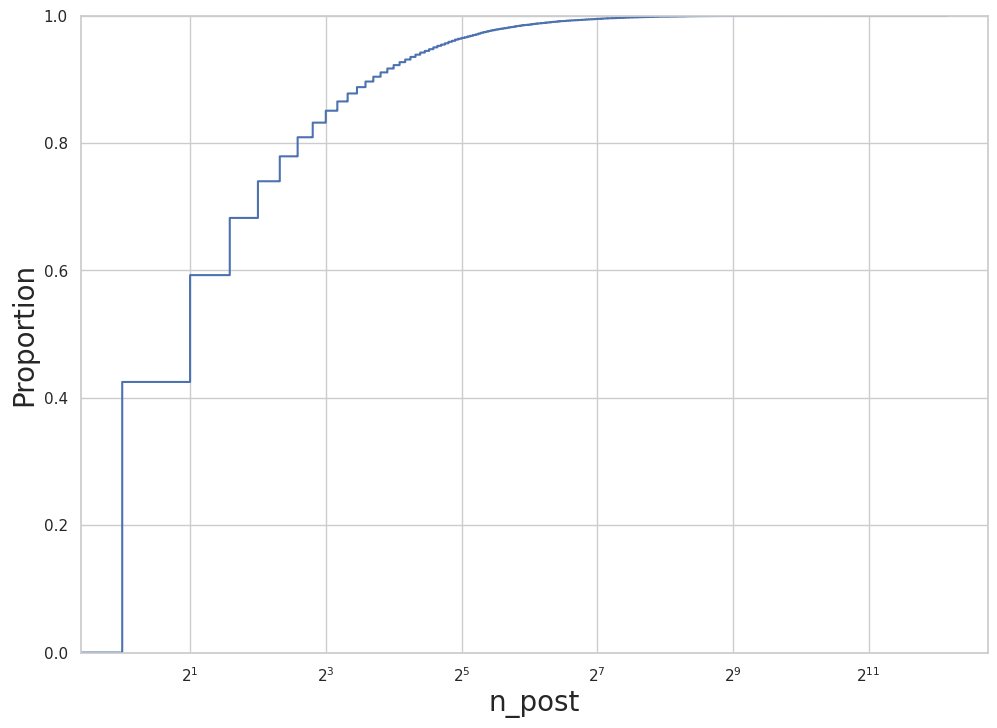

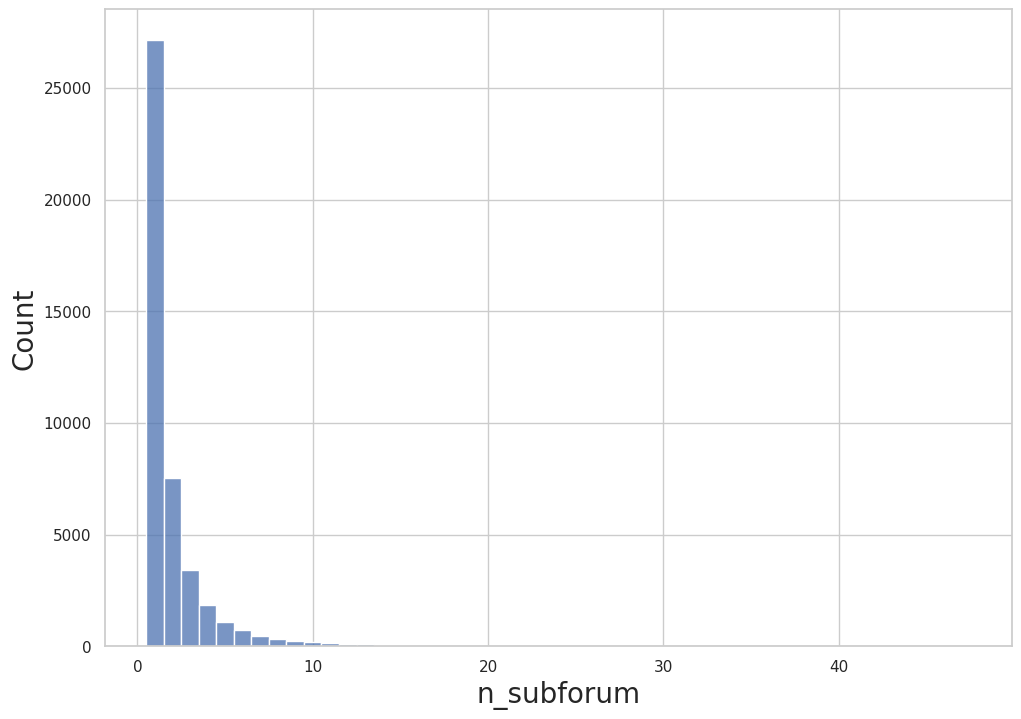

In [8]:
table = duckdb.read_json("/data/ccc/data/dread_all.jsonl")
conn = duckdb.register("dread", table)
plot_config = PlotConfig(2, False, 50)
outputs = basic_stats(conn, dread_config, plot_config)

***
## The Hub

Num authors:  8243
Num Posts:  88753
Total subforums:  62
Authors with n_subforum above thresh (>= 30):  [(2, 32), (1076, 32), (7, 30), (6447, 36), (34428, 36), (34544, 30), (58382, 31), (-1, 42)]


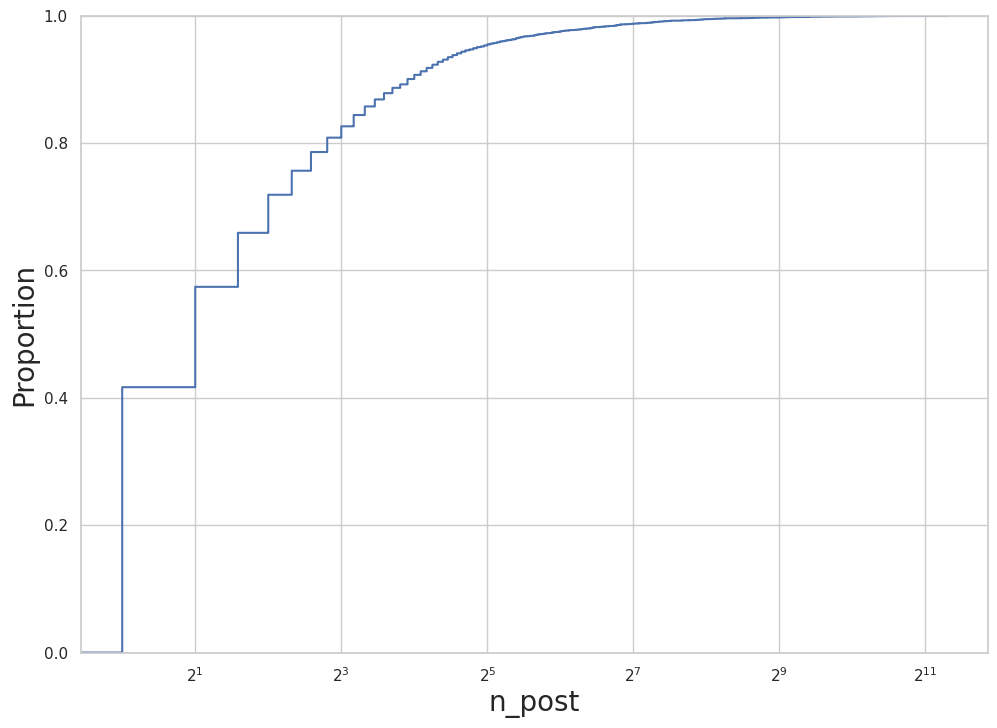

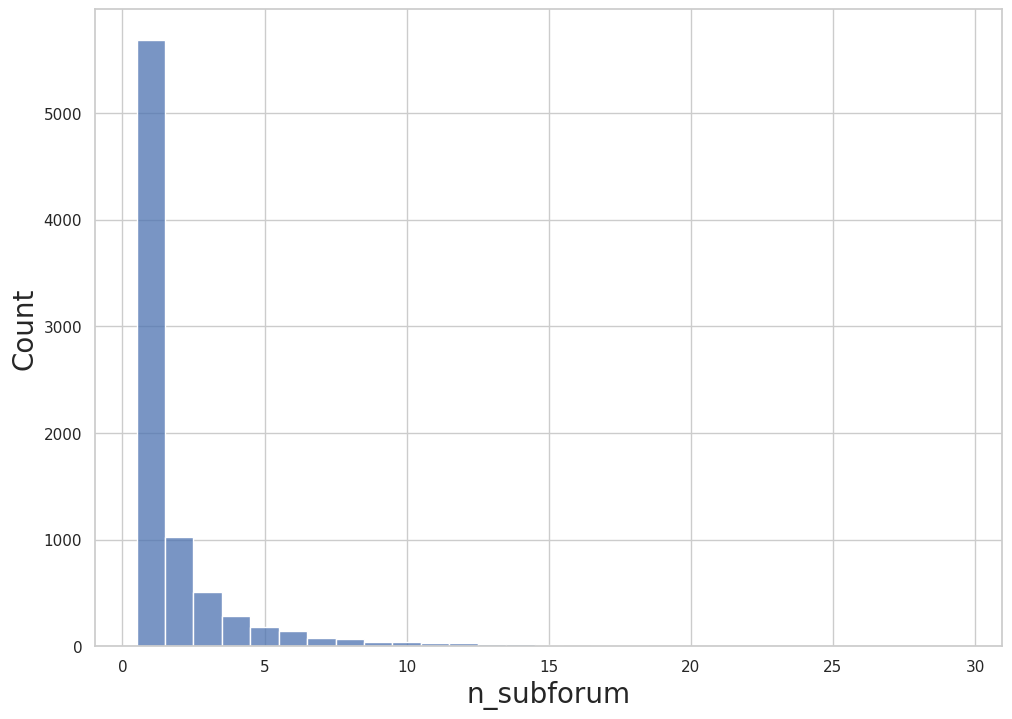

In [7]:
table = duckdb.read_json("/data/ccc/data/thehub_all.jsonl")
conn = duckdb.register("dread", table)
plot_config = PlotConfig(2, False, 30)
plots = basic_stats(conn, dread_config, plot_config)


***
## Reddit 2018 Jan

Num authors:  4413757
Num Posts:  82531775


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total subforums:  94945


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Authors with n_subforum above thresh (>= 100):  [('KaribouLouDied', 111), ('MegaAlex', 114), ('shit_poster9000', 109), ('gazongas001', 256), ('KennethMcCarthy', 129), ('PokWangpanmang', 115), ('IgnatiusPortabello', 102), ('SuperFLEB', 101), ('LouisSeaGays', 108), ('PrincessBananas85', 201), ('knowses', 103), ('joe579003', 103), ('InsertWitt', 104), ('Alias-_-Me', 107), ('octanemembrane_', 107), ('toeofcamell', 125), ('Jake0024', 100), ('ErikaLight', 122), ('MeatloafPopsicle', 101), ('MyStrangeUncles', 111), ('Zero_Ghost24', 115), ('only5cents', 185), ('heykevo', 139), ('madd74', 109), ('Victorian_Astronaut', 121), ('GetOffMyLawn_', 107), ('lydocia', 155), ('Sweet_Taurus0728', 131), ('TheMaStif', 103), ('NotTheOneYouNeed', 110), ('kjm1123490', 101), ('Swimmingindiamonds', 111), ('teuast', 113), ('Melechdaviid', 142), ('ThatOtherGuy_CA', 140), ('jahs_126', 120), ('trxbyx', 107), ('DigThatFunk', 103), ('Stompedyourhousewith', 116), ('congelar', 106), ('jppianoguy', 115), ('advertentlyvert

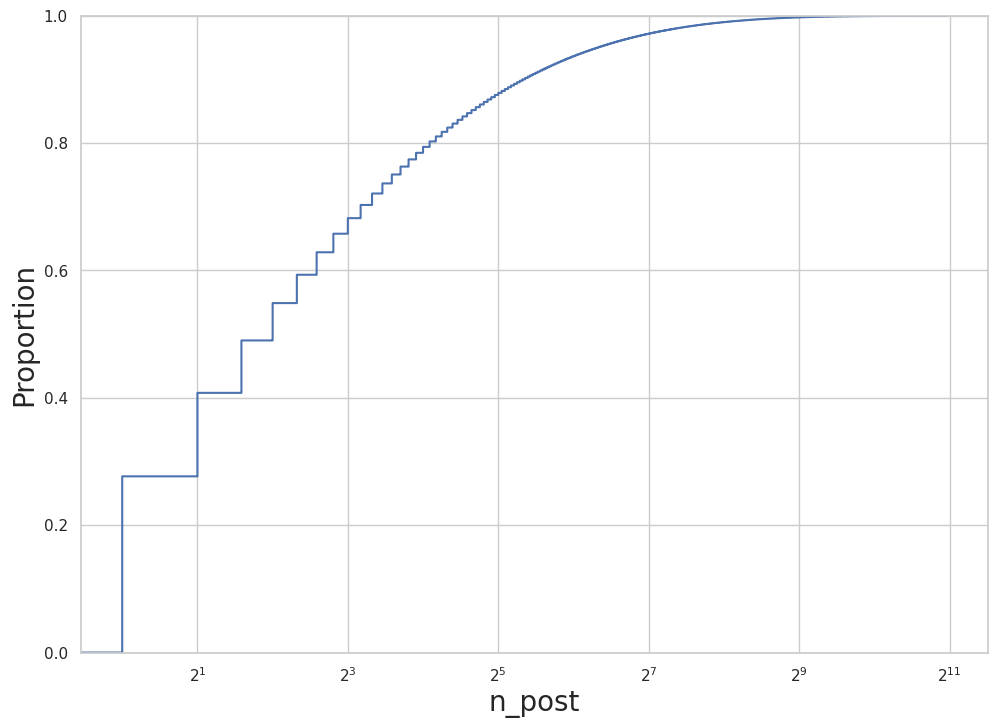

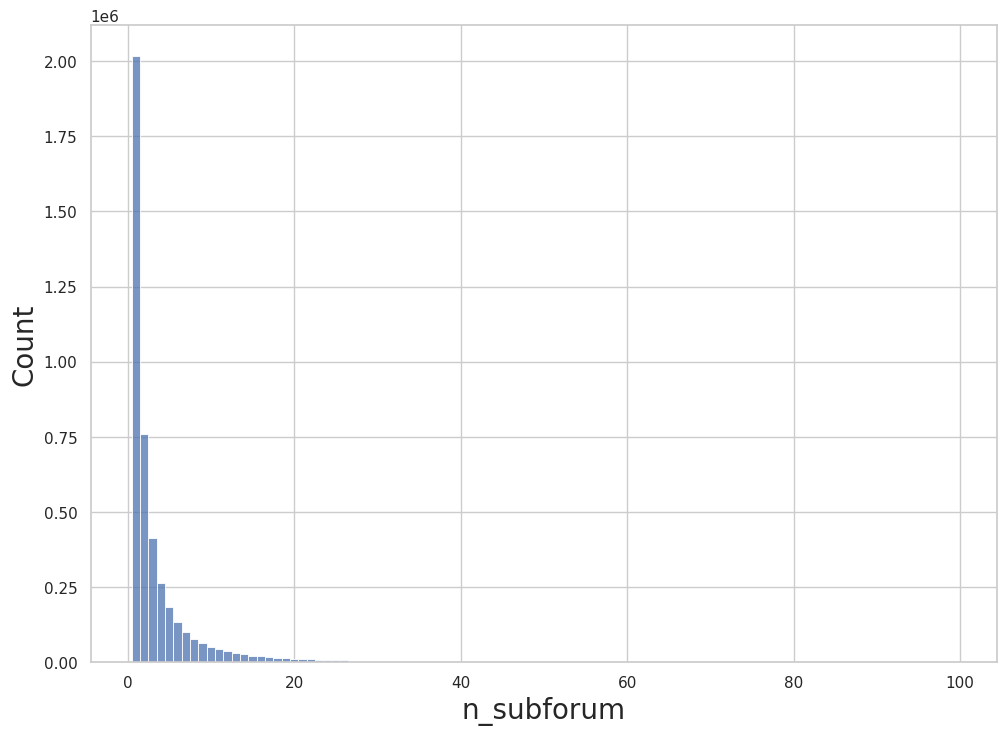

In [23]:
table = duckdb.read_json("/data/ccc/data/reddit_RC_2018_01")
conn = duckdb.register("reddit", table)
plot_config = PlotConfig(2, False, 100)
plots = basic_stats(conn, reddit_config, plot_config)

***
Reddit Dec 2019

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Num authors:  7439040


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Num Posts:  126992546


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total subforums:  155864


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Authors with n_subforum above thresh (>= 100):  [('Team_Pluto', 108), ('Scoot_Ya_Boot', 103), ('jupiter711', 124), ('Soviet_Saiyan', 118), ('HOCK88_', 128), ('cubed_circle', 145), ('Gameknight6916', 117), ('InsidePerformer', 100), ('memedealer22', 130), ('fergus73', 113), ('WrenchFriessAlt', 113), ('slimjoel14', 124), ('Dazgil1234', 141), ('Pistolero921', 115), ('mattypg84', 120), ('toeofcamell', 136), ('SEND_BOOBS_PLEASE_', 102), ('Country_girl1992', 124), ('The1930s', 126), ('swyeary', 297), ('Wallyfrank', 117), ('Curious9125', 105), ('Zombiepixlz-gamr', 100), ('labman32', 290), ('DabIMON', 104), ('gratitudeuity', 143), ('DarkNite0w0', 106), ('deny_death', 104), ('JuanWithTheDeagle', 107), ('MasterVule', 106), ('QuietRains813', 108), ('redditspeedbot', 195), ('Beach_Kitten', 114), ('joe579003', 106), ('kinkyslc1', 134), ('themeatbridge', 120), ('Nuggetmilk51', 100), ('theghostofme', 119), ('jikkler', 103), ('iWillNotLetYouGo', 148), ('TheHoundsOFLove', 105), ('BeerJunky', 141), ('kb3

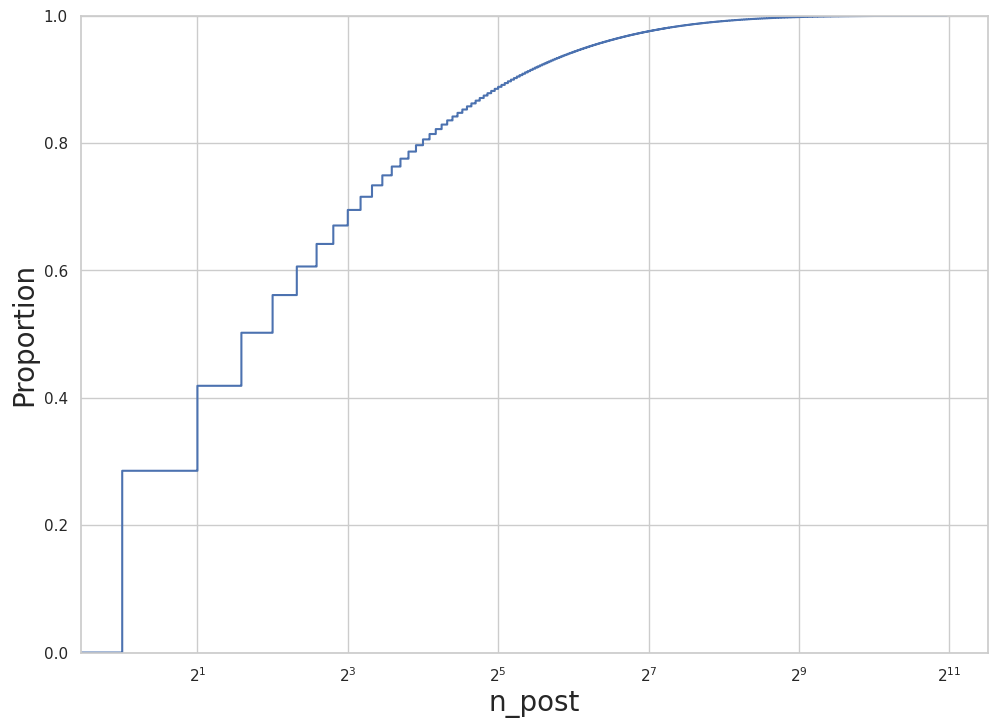

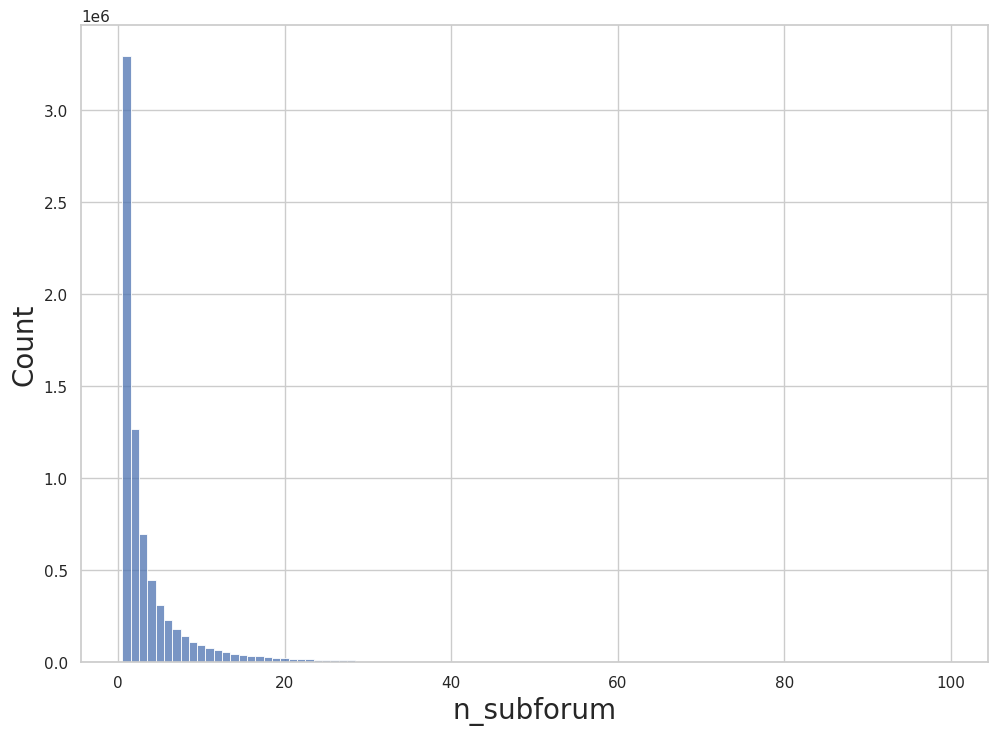

In [24]:
table = duckdb.read_json("/data/ccc/data/reddit_RC_2019_12")
conn = duckdb.register("reddit", table)
plot_config = PlotConfig(2, False, 100)
plots = basic_stats(conn, reddit_config, plot_config)

*** 
## Dataset splits for each

### Tests

In [13]:
# dread
table = duckdb.read_json("/data/ccc/data/dread_all.jsonl")
conn = duckdb.register("dread", table)
monthly_counts = duckdb.sql("SELECT year(to_timestamp(created_on)) as year, month(to_timestamp(created_on)) as month, COUNT(*) as n_post FROM \
                            (SELECT UNNEST(created_on) as created_on FROM dread) GROUP BY month, year ORDER BY year, month", connection=conn).df()

monthly_counts["c_post"] = monthly_counts["n_post"].cumsum()
total_count = monthly_counts["c_post"][len(monthly_counts)-1]


In [14]:
r_mid = bisect_left(monthly_counts["c_post"], total_count // 2)
train_count = monthly_counts["c_post"][r_mid - 1]
print("Mid point count:", train_count, " Total: ", total_count)
r_query = bisect_left(monthly_counts["c_post"], 3 * total_count // 4)
q_count = monthly_counts["c_post"][r_query] - train_count
t_count = total_count - q_count - train_count
print("Query: ", q_count, " Target: ", t_count)

Mid point count: 146171  Total:  294596
Query:  93557  Target:  54868


In [15]:
output_train = "final/dread/train.jsonl"
output_query = "final/dread/test_queries.jsonl"
output_target = "final/dread/test_targets.jsonl"
c = dread_config

In [54]:
year, month = monthly_counts.iloc[r_mid][["year", "month"]]
print(year, month)
r_utc = int(datetime(year, month, 1).timestamp())
print(r_utc)
duckdb.sql(f" COPY (\
            SELECT id[:r_idx+1] as id, {c.utc}[:r_idx+1] as {c.utc}, \
                 {c.body}[:r_idx+1] as {c.body}, {c.subforum}[:r_idx+1] as {c.subforum}, {c.author}  FROM \
             (SELECT \
                list_max([idx for idx in range(len({c.utc})) \
                 if {c.utc}[idx] < {r_utc}]) as r_idx, \
                 id, {c.utc}, {c.body}, {c.subforum}, {c.author}\
              FROM dread) t WHERE r_idx is NOT NULL AND r_idx > 0) TO '{output_train}' (FORMAT JSON);")

2019 7
1561953600


In [55]:
!wc -l {output_train}

14618 final/dread/train.jsonl


In [56]:
df = pd.read_json(output_train, orient="records", lines=True)
df["id"].apply(len).describe()

count    14618.000000
mean        14.137296
std         51.748203
min          2.000000
25%          3.000000
50%          5.000000
75%         12.000000
max       4536.000000
Name: id, dtype: float64

In [60]:
q_t = duckdb.sql(f"SELECT id[r_idx:] as id, {c.utc}[r_idx:] as {c.utc}, \
                 {c.body}[r_idx:] as {c.body}, {c.subforum}[r_idx:] as {c.subforum}, {c.author}  FROM \
             (SELECT list_min([idx for idx in range(len({c.utc})) \
                 if {c.utc}[idx] >= {r_utc}]) as r_idx, \
                 id, {c.utc}, {c.body}, {c.subforum}, {c.author}\
              FROM dread) t WHERE len(id) - r_idx + 1  > 1").df()

In [62]:
non_auth_cols = ["id", c.body, c.subforum, c.utc]
with open(output_query, "w") as q:
    with open(output_target, "w") as t:
        for idx, r in tqdm(q_t.iterrows()):
            n_posts = len(r["id"])
            query = {col: r[col][:n_posts//2] for col in non_auth_cols}
            query[c.author] = r[c.author]
            query["author_idx"] = idx
            q.write(json.dumps(query))
            q.write("\n")

            target = {col: r[col][n_posts//2:] for col in non_auth_cols}
            target[c.author] = r[c.author]
            target["author_idx"] = idx
            t.write(json.dumps(target))
            t.write("\n")

  0%|          | 0/19493 [00:00<?, ?it/s]

TypeError: __getitem__(): incompatible function arguments. The following argument types are supported:
    1. (self: duckdb.DuckDBPyRelation, name: str) -> duckdb.DuckDBPyRelation

Invoked with: ┌──────────────────────┬──────────────────────┬──────────────────────┬─────────────────────────┬───────────────────────┐
│          id          │      created_on      │       content        │          board          │        creator        │
│       int64[]        │       int64[]        │      varchar[]       │        varchar[]        │        varchar        │
├──────────────────────┼──────────────────────┼──────────────────────┼─────────────────────────┼───────────────────────┤
│ [274910107, 168135…  │ [1565244139, 15190…  │ [I'm curios about …  │ [DarkNetMarkets, Dark…  │ shoot762x39           │
│ [879807560, 144769…  │ [1565219205, 15198…  │ [When ordering I w…  │ [WallStreetMarket, Da…  │ fr33onT00             │
│ [326647020, 181010…  │ [1565108744, 15188…  │ [Hello there I am …  │ [freelance, Forgeries…  │ ForgeriesPlus         │
│ [6111255, 20584125…  │ [1565107363, 15188…  │ [This site looks g…  │ [Forgeries, FakeID, F…  │ forever21id           │
│ [834468391, 932238…  │ [1565283065, 15652…  │ [Arrived 2DD\n\nBo…  │ [DNMUK, DNMUK, DNMUK,…  │ Peacockquill          │
│ [1010617069, 55643…  │ [1565243705, 15652…  │ [I read that havin…  │ [DarkNetMarkets, DNMU…  │ dogglegg              │
│ [1900754493, 19219…  │ [1565107711, 15239…  │ [Hey everyone, MTE…  │ [RCBenzos, RCBenzos, …  │ Brownnote66           │
│ [409148732, 363470…  │ [1565243970, 15652…  │ [Hello everyone; a…  │ [DarkNetMarkets, Lean…  │ dripdrop              │
│ [1293921199, 17180…  │ [1565213325, 15284…  │ [Hello everyone,\n…  │ [WallStreetMarket, Wa…  │ ficklestone           │
│ [1090360742, 14493…  │ [1565284041, 15196…  │ [4FA is something …  │ [DNMUK, DNMUK, DNMUK,…  │ Tepidtwostone         │
│          ·           │          ·           │          ·           │            ·            │  ·                    │
│          ·           │          ·           │          ·           │            ·            │  ·                    │
│          ·           │          ·           │          ·           │            ·            │  ·                    │
│ [1281794674, 11643…  │ [1565226684, 15652…  │ [I have never had …  │ [DarkNetMarkets, frau…  │ svm                   │
│ [2114589350, 17585…  │ [1565226693, 15652…  │ [Updates\n-New str…  │ [Apollon, Apollon]      │ DoctorCannabis VENDOR │
│ [596576183, 170825…  │ [1565226694, 15723…  │ [Not sourcing or l…  │ [DarkNetMarkets, DNMU…  │ Paksta01              │
│ [1979403652, 18355…  │ [1565226701, 15652…  │ [Hey guys sent you…  │ [Apollon, Apollon, Ap…  │ Medicalgreens VENDOR  │
│ [1181402196, 74875…  │ [1565226717, 15639…  │ [Hey Guys, Apollon…  │ [Apollon, Apollon, Ap…  │ Freedomfighter VENDOR │
│ [330351375, 943463…  │ [1565226726, 15653…  │ [Hey everyone, we …  │ [Apollon, EmpireMarke…  │ Bitcoinbanditz        │
│ [54791002, 1301615…  │ [1565226761, 15652…  │ [Can anyone vouch …  │ [DarkNetMarkets, Drea…  │ Going_Dumb            │
│ [689028486, 999540…  │ [1565226762, 15652…  │ [***LINK***[NL > E…  │ [Apollon, Apollon, Ap…  │ kruidvat VENDOR       │
│ [152242822, 822478…  │ [1565226777, 15526…  │ [what are some ele…  │ [DarkNetMarkets, Tail…  │ xmrhelpplease         │
│ [225683442, 316179…  │ [1565226784, 15639…  │ [***LINK***CLICK H…  │ [Apollon, Apollon, Ap…  │ Gfellas VENDOR        │
├──────────────────────┴──────────────────────┴──────────────────────┴─────────────────────────┴───────────────────────┤
│ ? rows (>9999 rows, 20 shown)                                                                              5 columns │
└──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘
, 0

In [48]:
q_t["id"].apply(len).describe()

count    19493.000000
mean        12.129534
std         44.973326
min          2.000000
25%          2.000000
50%          4.000000
75%         10.000000
max       4536.000000
Name: id, dtype: float64

### Final

In [9]:
max_count = 2000
def two_part_split(df, query_path, target_path, config):
    c = config
    non_auth_cols = ["id", c.body, c.subforum, c.utc]
    with open(query_path, "w") as q:
        with open(target_path, "w") as t:
            for idx, r in tqdm(df.iterrows()):
                n_posts = len(r["id"])
                query = {col: r[col][:n_posts//2] for col in non_auth_cols}
                query[c.author] = r[c.author]
                query["author_idx"] = idx
                q.write(json.dumps(query))
                q.write("\n")

                target = {col: r[col][n_posts//2:] for col in non_auth_cols}
                target[c.author] = r[c.author]
                target["author_idx"] = idx
                t.write(json.dumps(target))
                t.write("\n")


def create_standardized_data(jsonl_path, table_name, output_train, output_query, output_target,
                              config, split_second=True):
    table = duckdb.read_json(jsonl_path)
    conn = duckdb.register(table_name, table)
    c = config

    mid_point = duckdb.sql(f"SELECT median({c.utc}) as mid_point FROM \
                           (SELECT unnest({c.utc}) as {c.utc}  FROM {table_name}) t", connection=conn).fetchone()[0]

    r_utc = mid_point
    print("Generating first half")
    duckdb.sql(f" COPY (\
                SELECT id[:r_idx+1] as id, {c.utc}[:r_idx+1] as {c.utc}, \
                    {c.body}[:r_idx+1] as {c.body}, {c.subforum}[:r_idx+1] as {c.subforum}, {c.author}  FROM \
                (SELECT \
                    list_max([idx for idx in range(len({c.utc})) \
                    if {c.utc}[idx] < {r_utc}]) as r_idx, \
                    id, {c.utc}, {c.body}, {c.subforum}, {c.author}\
                FROM {table_name}) t WHERE r_idx is NOT NULL AND r_idx > 1  AND len(id) < {max_count}) TO '{output_train}' (FORMAT JSON);")
    
    q_t = duckdb.sql(f"SELECT id[r_idx:] as id, {c.utc}[r_idx:] as {c.utc}, \
                 {c.body}[r_idx:] as {c.body}, {c.subforum}[r_idx:] as {c.subforum}, {c.author}  FROM \
             (SELECT list_min([idx for idx in range(len({c.utc})) \
                 if {c.utc}[idx] >= {r_utc}]) as r_idx, \
                 id, {c.utc}, {c.body}, {c.subforum}, {c.author}\
              FROM {table_name}) t WHERE len(id) - r_idx + 1  > 1 AND len(id) < {max_count}").df()

    print("Generating second half")
    if split_second: 
        two_part_split(q_t, output_query, output_target, c)
    else:
        df.to_json(output_query, orient="records", lines=True)

In [10]:
create_standardized_data("/data/ccc/data/dread_all.jsonl", "dread", "final/dread/train.jsonl", "final/dread/test_queries.jsonl", "final/dread/test_targets.jsonl", dread_config)

Generating first half


Generating second half


0it [00:00, ?it/s]

In [11]:
create_standardized_data("/data/ccc/data/thehub_all.jsonl", "thehub", "final/thehub/train.jsonl", "final/thehub/test_queries.jsonl", "final/thehub/test_targets.jsonl", dread_config)

Generating first half
Generating second half


0it [00:00, ?it/s]

### Reddit Sample

In [13]:
akey = dread_config.author
duckdb.sql(f"SELECT COUNT(DISTINCT({akey})), AVG(n_id), MIN(n_id), MAX(n_id) FROM \
           (SELECT {akey}, COUNT(id) as n_id FROM \
            (SELECT unnest(id) as id, {akey} FROM read_json_auto('final/dread/train.jsonl') UNION \
             SELECT unnest(id) as id, {akey} FROM read_json_auto('final/dread/test_queries.jsonl') UNION \
            SELECT unnest(id) as id, {akey} FROM read_json_auto('final/dread/test_targets.jsonl')) \
             GROUP BY {akey})")

┌────────────────────────────┬────────────────────┬───────────┬───────────┐
│ count(DISTINCT creator_id) │     avg(n_id)      │ min(n_id) │ max(n_id) │
│           int64            │       double       │   int64   │   int64   │
├────────────────────────────┼────────────────────┼───────────┼───────────┤
│                      22229 │ 11.927032255162176 │         2 │      1398 │
└────────────────────────────┴────────────────────┴───────────┴───────────┘

In [16]:
n_rows = 22230

### 2018-01

In [14]:
jsonl_path = "/data/ccc/data/reddit_RC_2018_01"
sampled_df = duckdb.sql(f"SELECT * FROM \
                         (SELECT * FROM read_json_auto('{jsonl_path}') \
                          WHERE len(id) >= 2 AND len(id) <= 1400) t \
                          USING SAMPLE {n_rows} ROWS;").df()
print(len(sampled_df))
sampled_df.to_json("/data/ccc/data/reddit_RC_2018_01_sample.jsonl", orient="records", lines=True)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

22230


In [15]:
create_standardized_data("/data/ccc/data/reddit_RC_2018_01_sample.jsonl", "reddit_2018", 
                         "final/reddit_2018_sample/train.jsonl", "final/reddit_2018_sample/test_queries.jsonl", "final/reddit_2018_sample/test_targets.jsonl", reddit_config)

Generating first half
Generating second half


0it [00:00, ?it/s]

### 2019-12

In [17]:
jsonl_path = "/data/ccc/data/reddit_RC_2019_12"
sampled_df = duckdb.sql(f"SELECT * FROM \
                         (SELECT * FROM read_json_auto('{jsonl_path}') \
                          WHERE len(id) >= 2 AND len(id) <= 1600) t \
                          USING SAMPLE {n_rows} ROWS;").df()

sampled_df.to_json("/data/ccc/data/reddit_RC_2019_12_sample.jsonl", orient="records", lines=True)
create_standardized_data("/data/ccc/data/reddit_RC_2019_12_sample.jsonl", "reddit_2019", 
                         "final/reddit_2019_sample/train.jsonl", "final/reddit_2019_sample/test_queries.jsonl", "final/reddit_2019_sample/test_targets.jsonl", reddit_config)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Generating first half
Generating second half


0it [00:00, ?it/s]

# Big Half Splits

In [18]:
max_count = 2000
def create_half_splits(main_jsonl, output_dir, config, sample_size=None):
    os.makedirs(output_dir, exist_ok=True)
    all_rows = duckdb.sql(f"SELECT * FROM read_json_auto('{main_jsonl}') \
                          WHERE len(id) >= 2 AND len(id) <= {max_count}").df()
    two_part_split(all_rows, os.path.join(output_dir, "queries.jsonl"),
                   os.path.join(output_dir, "targets.jsonl"), config)

In [19]:
create_half_splits("/data/ccc/data/dread_all.jsonl", "final/two_part/dread/", dread_config)

0it [00:00, ?it/s]

In [20]:
create_half_splits("/data/ccc/data/thehub_all.jsonl", "final/two_part/thehub/", dread_config)

0it [00:00, ?it/s]

In [21]:
create_half_splits("/data/ccc/data/reddit_RC_2018_01_sample.jsonl", "final/two_part/reddit_2018_sample/", reddit_config)
create_half_splits("/data/ccc/data/reddit_RC_2019_12_sample.jsonl", "final/two_part/reddit_2019_sample/", reddit_config)

0it [00:00, ?it/s]

0it [00:00, ?it/s]